[Time 1] Phase=0 Action=0 QueueNS=18 QueueEW=32 Reward=-2.8 Toll=4.5 Cleared=0/50
[Time 2] Phase=1 Action=1 QueueNS=18 QueueEW=32 Reward=-2.8 Toll=4.5 Cleared=0/50
[Time 3] Phase=1 Action=0 QueueNS=18 QueueEW=32 Reward=-2.8 Toll=4.5 Cleared=0/50
[Time 4] Phase=0 Action=1 QueueNS=18 QueueEW=32 Reward=-2.8 Toll=4.5 Cleared=0/50
[Time 5] Phase=0 Action=0 QueueNS=18 QueueEW=32 Reward=-2.8 Toll=4.5 Cleared=0/50
[Time 6] Phase=1 Action=1 QueueNS=18 QueueEW=31 Reward=-1.6 Toll=4.45 Cleared=1/50
[Time 7] Phase=1 Action=0 QueueNS=18 QueueEW=30 Reward=-1.4 Toll=4.4 Cleared=2/50
[Time 8] Phase=0 Action=1 QueueNS=18 QueueEW=30 Reward=-2.4 Toll=4.4 Cleared=2/50
[Time 9] Phase=1 Action=1 QueueNS=18 QueueEW=30 Reward=-2.4 Toll=4.4 Cleared=2/50
[Time 10] Phase=1 Action=0 QueueNS=18 QueueEW=30 Reward=-2.4 Toll=4.4 Cleared=2/50
[Time 11] Phase=0 Action=1 QueueNS=17 QueueEW=30 Reward=-1.6 Toll=4.35 Cleared=3/50
[Time 12] Phase=0 Action=0 QueueNS=16 QueueEW=30 Reward=-1.8 Toll=4.3 Cleared=4/50
[Time 13] P

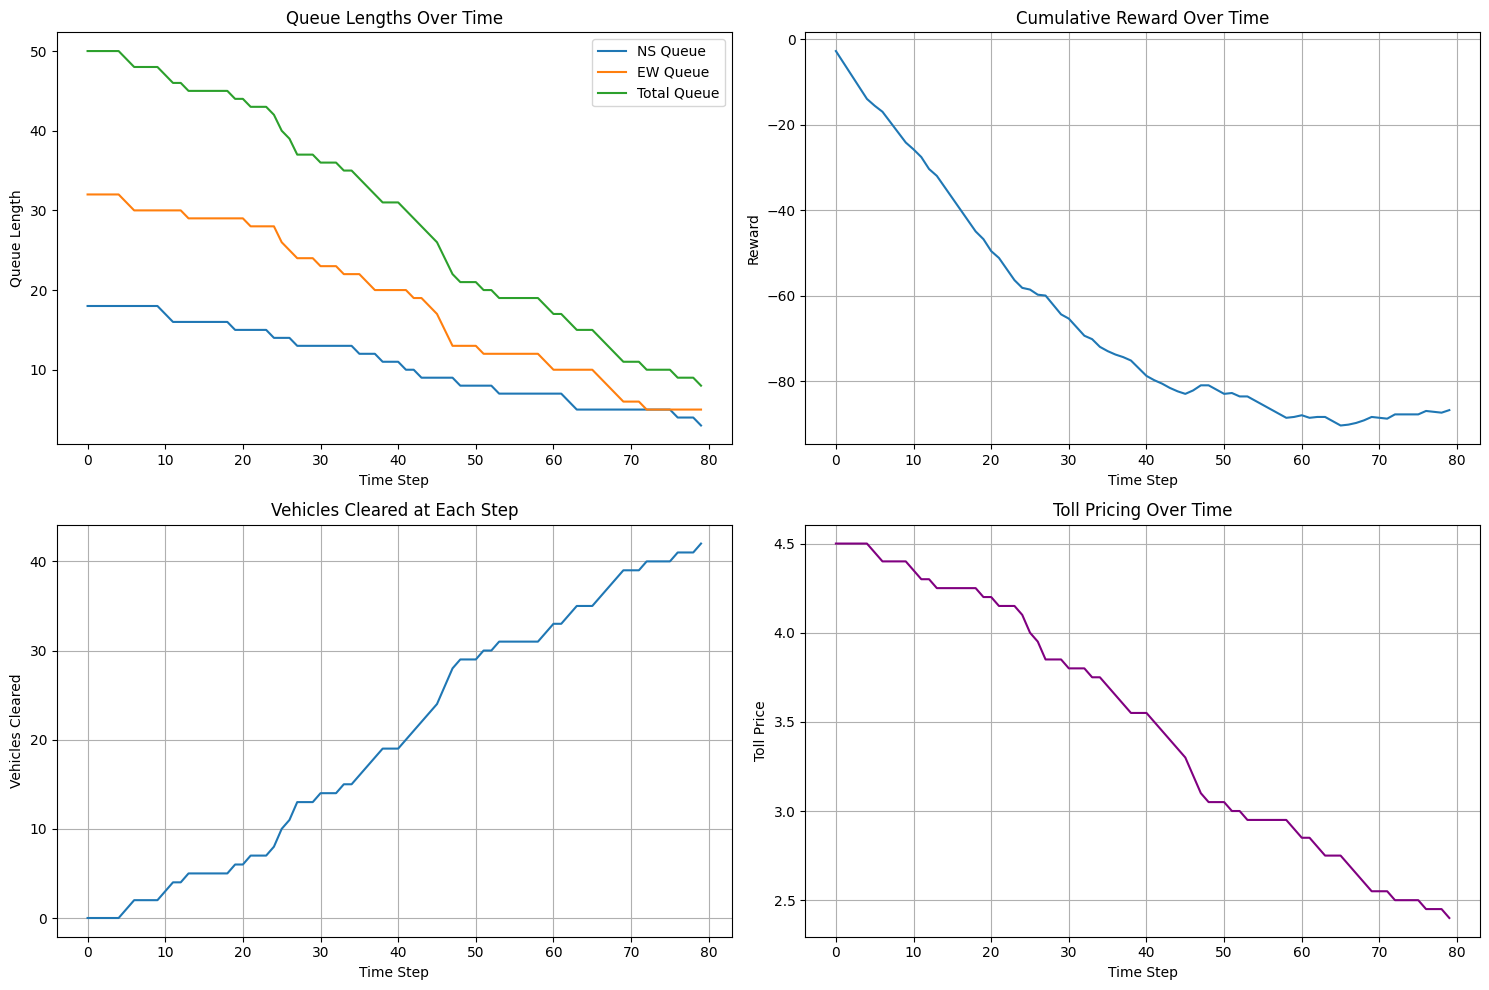


Top Q-values learned:
State=(2, 3, 1), Q-values=[0.1347472, 0.0]
State=(4, 7, 1), Q-values=[0.12, 0.0]
State=(2, 4, 1), Q-values=[0.09599999999999999, 0.0]
State=(2, 2, 0), Q-values=[0.09474720000000002, 0.0]
State=(4, 8, 1), Q-values=[0.07999999999999999, 0.0]
State=(3, 5, 1), Q-values=[-0.020400000000000015, 0.019999999999999997]
State=(2, 5, 1), Q-values=[0.019999999999999997, 0.0]
State=(5, 9, 0), Q-values=[-0.1, 0.0]
State=(4, 6, 1), Q-values=[-0.06020000000000001, 0.0]
State=(3, 5, 0), Q-values=[0.0, 0.0]


In [4]:
import random
import numpy as np
from collections import defaultdict, deque

##############################
# AGENT: Traffic Light (RL) #
##############################

class TrafficLightAgent:
    """
    A traffic light agent that uses a simple Q-learning mechanism to switch phases.
    For demonstration, we assume a single intersection with 2 phases:
      - Phase 0: Green for NS (north-south), Red for EW (east-west)
      - Phase 1: Green for EW, Red for NS

    State variables (simplified):
      - queue_length_ns: The approximate queue length or waiting vehicles on NS roads
      - queue_length_ew: The approximate queue length on EW roads
      - current_phase: Which phase is active now?

    Action:
      - 0 => keep the same phase
      - 1 => switch the phase

    Reward:
      - Negative sum of average waiting time or total queue, or a function that encourages balancing traffic.
    """

    def __init__(self, agent_id, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.agent_id = agent_id
        # Q-table: dict with key=(queue_length_ns, queue_length_ew, current_phase) => value=Q-values for actions [0,1]
        self.Q = defaultdict(lambda: [0.0, 0.0])

        self.alpha = alpha    # learning rate
        self.gamma = gamma    # discount factor
        self.epsilon = epsilon # exploration rate

        self.current_phase = 0  # Start with phase 0 (e.g., NS green, EW red)
        self.last_state = None
        self.last_action = None


    def get_state(self, queue_length_ns, queue_length_ew):
        # Discretize queue lengths to keep the Q-table manageable (toy approach).
        # In a real system, you would have better state representation, possibly neural nets.
        q_ns = min(queue_length_ns // 2, 10)  # bucket queue lengths
        q_ew = min(queue_length_ew // 2, 10)
        return (q_ns, q_ew, self.current_phase)

    def choose_action(self, state):
        """
        Epsilon-greedy policy: choose best known action or random.
        """
        if random.random() < self.epsilon:
            # explore
            return random.choice([0, 1])
        else:
            # exploit
            q_values = self.Q[state]
            return np.argmax(q_values)

    def update_q(self, reward, next_state):
        """
        Update Q-table based on the last state, action, reward, and next_state.
        """
        if self.last_state is None or self.last_action is None:
            return  # skip if this is the first step

        old_q = self.Q[self.last_state][self.last_action]
        next_max = max(self.Q[next_state])

        new_q = old_q + self.alpha * (reward + self.gamma * next_max - old_q)
        self.Q[self.last_state][self.last_action] = new_q

    def step(self, queue_length_ns, queue_length_ew):
        """
        One time step for the traffic light.
          1. Observe state
          2. Choose an action
          3. Return the chosen action so the environment can apply it
        """
        state = self.get_state(queue_length_ns, queue_length_ew)
        action = self.choose_action(state)

        self.last_state = state
        self.last_action = action

        # If action=1, we toggle the phase
        if action == 1:
            self.current_phase = 1 - self.current_phase



        return action

    def on_environment_feedback(self, reward, next_queue_length_ns, next_queue_length_ew):
        """
        Environment calls this after it calculates a reward from the last action.
        """
        next_state = self.get_state(next_queue_length_ns, next_queue_length_ew)
        self.update_q(reward, next_state)


##########################
# AGENT: Vehicle (V2I)   #
##########################

class VehicleAgent:
    """
    A simple vehicle agent. In a real system, each vehicle might publish speed, location, etc. to the environment.
    Here, we track:
      - route: 'NS' or 'EW' or 'EMERGENCY' route
      - position: we simply store queue position or how close to intersection in a toy sense
    This agent can communicate with the environment (e.g., to get new route, to handle re-routing).
    """

    def __init__(self, vehicle_id, route, is_emergency=False):
        self.vehicle_id = vehicle_id
        self.route = route
        self.is_emergency = is_emergency
        # For simplicity, 'position' could be an integer representing distance from intersection
        self.position = random.randint(5, 50)  # start some distance away

    def move(self, traffic_light_phase, dt=1):
        """
        Move closer to intersection if the light is green for us or we have an emergency priority.
        """
        # If vehicle is on NS route and traffic_light_phase == 0 => it's green for NS
        # If vehicle is on EW route and traffic_light_phase == 1 => it's green for EW
        # If vehicle is emergency => maybe skip the wait or get special priority
        can_move = False
        if self.is_emergency:
            # emergency vehicles can force a priority. They might be allowed to move regardless, or we do special logic
            can_move = True
        else:
            if self.route == 'NS' and traffic_light_phase == 0:
                can_move = True
            elif self.route == 'EW' and traffic_light_phase == 1:
                can_move = True

        if can_move and self.position > 0:
            self.position -= 1  # move 1 unit closer
        # If position <= 0, we consider it to have cleared the intersection

    def has_cleared_intersection(self):
        return self.position <= 0


#########################
# AGENT: Drone (Extra)  #
#########################

class DroneAgent:
    """
    Drone agent that can gather overhead data about unusual events (accidents, blockages).
    For demonstration, it periodically checks the environment for random 'accidents' or 'blocks'.
    """
    def __init__(self, drone_id):
        self.drone_id = drone_id

    def scan_for_incidents(self):
        """
        Toy logic: 5% chance of finding an incident each time it's called.
        Returns either None (no incident) or a dict describing the incident.
        """
        if random.random() < 0.05:
            # Return a random 'incident' that might block a route
            route = random.choice(['NS', 'EW'])
            return {
                'type': 'ACCIDENT',
                'route': route,
                'duration': random.randint(2, 5)  # how many steps it lasts
            }
        return None


########################
# AGENT: Toll Pricing  #
########################

class TollAgent:
    """
    Agent that adjusts tolls based on congestion levels.
    Suppose we have a toll booth for entering the city from a certain route.
    The agent monitors queue lengths, sets toll = base + some function of queue length.
    """
    def __init__(self, base_toll=1.0, max_toll=5.0):
        self.base_toll = base_toll
        self.max_toll = max_toll
        self.current_toll = base_toll

    def update_toll(self, queue_ns, queue_ew):
        # Example: toll is proportional to total queue, but capped
        load_factor = (queue_ns + queue_ew) / 20.0
        self.current_toll = min(self.base_toll + load_factor, self.max_toll)
        return self.current_toll


#####################################
# ENVIRONMENT / SIMULATION MANAGER  #
#####################################

class TrafficEnvironment:
    """
    Manages the simulation of one intersection with multi-agent interactions.

    - We have one TrafficLightAgent controlling the signals.
    - We have multiple VehicleAgents (some may be emergency).
    - A DroneAgent to detect random incidents.
    - A TollAgent for dynamic toll pricing.

    The environment runs in discrete time steps:
      1. The environment calculates the queue lengths.
      2. TrafficLightAgent picks an action (switch or stay).
      3. All vehicles move if permitted.
      4. Calculate reward, environment calls traffic light agent with the reward.
      5. Possibly detect incidents, block routes if needed.
      6. Output stats.
    """
    def __init__(self, num_vehicles=20, emergency_vehicle_probability=0.1):
        self.time_step = 0

        # Agents
        self.traffic_light_agent = TrafficLightAgent(agent_id="TL1")
        self.drone_agent = DroneAgent("DRONE1")
        self.toll_agent = TollAgent(base_toll=2.0, max_toll=10.0)

        # Generate vehicles
        self.vehicles = []
        for i in range(num_vehicles):
            route = random.choice(['NS','EW'])
            is_emer = (random.random() < emergency_vehicle_probability)
            vehicle = VehicleAgent(vehicle_id=f"veh_{i}", route=route, is_emergency=is_emer)
            self.vehicles.append(vehicle)

        # For blocking events
        self.blocked_routes = {
            'NS': 0,  # how many steps route is blocked
            'EW': 0
        }
        self.incidents = []  # store ongoing incidents
        self.total_reward_history = []
        self.history = {
            "time": [],
            "queue_ns": [],
            "queue_ew": [],
            "total_queue": [],
            "reward": [],
            "toll": [],
            "cleared": []
        }

    def get_queue_lengths(self):
        """
        Count how many vehicles of each route are waiting (position > 0).
        If the route is blocked, that also impacts the queue length.
        """
        ns_queue = sum(1 for v in self.vehicles if (v.route == 'NS') and (not v.has_cleared_intersection()))
        ew_queue = sum(1 for v in self.vehicles if (v.route == 'EW') and (not v.has_cleared_intersection()))
        return ns_queue, ew_queue

    def compute_reward(self, old_queues, new_queues):
        """
        Reward function example:
         - We measure the difference in total queue length (or waiting time).
         - Alternatively, we can do negative of total queue to encourage smaller queue.
         - We also incorporate fairness or penalty if one queue is far bigger than the other.
        """
        old_total = sum(old_queues)
        new_total = sum(new_queues)
        diff = old_total - new_total  # if we reduced queue, we get positive reward
        # small fairness penalty if difference between NS & EW is too large
        fairness_penalty = abs(new_queues[0] - new_queues[1]) * 0.2

        reward = diff - fairness_penalty
        return reward

    def apply_blockages(self, vehicle):
        """
        If the route is blocked, the vehicle won't move further. This simulates traffic jam from an incident.
        """
        if self.blocked_routes[vehicle.route] > 0:
            # if route is blocked, do not allow any movement for normal vehicles
            if not vehicle.is_emergency:
                return True  # yes, it's blocked
            # if is emergency, we can decide they can bypass or partially blocked
            # for simplicity, let's allow them to keep moving.
        return False

    def step(self):
        self.time_step += 1
        # 1. measure queue
        queue_ns, queue_ew = self.get_queue_lengths()

        # 2. traffic light agent picks action
        action = self.traffic_light_agent.step(queue_ns, queue_ew)
        current_phase = self.traffic_light_agent.current_phase

        # 3. vehicles move
        for v in self.vehicles:
            if not v.has_cleared_intersection():
                blocked = self.apply_blockages(v)
                if not blocked:
                    v.move(current_phase)

        # 4. measure new queue, compute reward
        new_queue_ns, new_queue_ew = self.get_queue_lengths()
        reward = self.compute_reward((queue_ns, queue_ew), (new_queue_ns, new_queue_ew))
        self.traffic_light_agent.on_environment_feedback(reward, new_queue_ns, new_queue_ew)
        self.total_reward_history.append(reward)

        # 5. drone checks incidents
        incident = self.drone_agent.scan_for_incidents()
        if incident is not None:
            print(f"[Time {self.time_step}] Drone found incident: {incident}")
            self.incidents.append((incident, self.time_step))
            self.blocked_routes[incident['route']] = incident['duration']

        # Decrease the timers for blocks
        for route in self.blocked_routes:
            if self.blocked_routes[route] > 0:
                self.blocked_routes[route] -= 1

        # Remove any expired incidents
        # not strictly needed, but you might want to track them
        for i, (inc, start_time) in enumerate(self.incidents):
            if self.time_step - start_time >= inc['duration']:
                # incident ended
                pass

        # 6. toll agent update
        current_toll = self.toll_agent.update_toll(new_queue_ns, new_queue_ew)

        # Stats
        cleared = sum(1 for v in self.vehicles if v.has_cleared_intersection())
        total_vehicles = len(self.vehicles)
        print(f"[Time {self.time_step}] Phase={current_phase} Action={action} "
              f"QueueNS={new_queue_ns} QueueEW={new_queue_ew} Reward={round(reward,2)} "
              f"Toll={round(current_toll,2)} Cleared={cleared}/{total_vehicles}")

        self.history["time"].append(self.time_step)
        self.history["queue_ns"].append(new_queue_ns)
        self.history["queue_ew"].append(new_queue_ew)
        self.history["total_queue"].append(new_queue_ns + new_queue_ew)
        self.history["reward"].append(reward)
        self.history["toll"].append(current_toll)
        self.history["cleared"].append(cleared)


#####################################
# MAIN: RUN A SAMPLE SIMULATION     #
#####################################

if __name__ == "__main__":
    # Example usage
    env = TrafficEnvironment(num_vehicles=50, emergency_vehicle_probability=0.2)

    # Run simulation
    for t in range(80):
        env.step()

    print("\nSimulation completed.")
    print("Collected total rewards:", env.total_reward_history)
    print("Average reward:", np.mean(env.total_reward_history))

    # ------------------------
    # Visualization Section
    # ------------------------
    import matplotlib.pyplot as plt
    time = list(range(len(env.total_reward_history)))

    # Plot Queue Lengths
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(time, env.history["queue_ns"], label="NS Queue")
    plt.plot(time, env.history["queue_ew"], label="EW Queue")
    plt.plot(time, env.history["total_queue"], label="Total Queue")
    plt.xlabel("Time Step")
    plt.ylabel("Queue Length")
    plt.title("Queue Lengths Over Time")
    plt.legend()

    # Plot Cumulative Reward
    plt.subplot(2, 2, 2)
    cumulative_rewards = np.cumsum(env.history["reward"])
    plt.plot(time, cumulative_rewards, label="Cumulative Reward")
    plt.xlabel("Time Step")
    plt.ylabel("Reward")
    plt.title("Cumulative Reward Over Time")
    plt.grid(True)

    # Vehicles Cleared Over Time
    plt.subplot(2, 2, 3)
    plt.plot(time, env.history["cleared"], label="Cleared Vehicles")
    plt.xlabel("Time Step")
    plt.ylabel("Vehicles Cleared")
    plt.title("Vehicles Cleared at Each Step")
    plt.grid(True)

    # Dynamic Toll Pricing
    plt.subplot(2, 2, 4)
    plt.plot(time, env.history["toll"], label="Dynamic Toll", color="purple")
    plt.xlabel("Time Step")
    plt.ylabel("Toll Price")
    plt.title("Toll Pricing Over Time")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Display Top Learned Q-Values
    print("\nTop Q-values learned:")
    for state, q_values in sorted(env.traffic_light_agent.Q.items(), key=lambda x: max(x[1]), reverse=True)[:10]:
        print(f"State={state}, Q-values={q_values}")
